In [1]:
%load_ext autoreload
%autoreload 2
%load_ext notexbook

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm
import networkx as nx


from generate_incomplete_graph import *

plt.style.use("../config/custom_plt.mplstyle")

In [2]:
base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/"
lastfm_graph = nx.read_edgelist(f"{base_path}/lastfm_asia_edges.edge")

In [3]:
g, missing_links = generate_incomplete_network_gcc(lastfm_graph, q=0.8)
len(missing_links)

Before: 7624 nodes. After: 3423 nodes


22244

In [4]:
import os

def experiment_generate_incomplete_networks(input_g, q_fractions, output_path, ntimes=5):
    for q in q_fractions:
        for i in range(ntimes):
            g, missing_links = generate_incomplete_network_gcc(input_g, q=q)
            
            str_q = str(q).replace('.', '_')
            os.makedirs(f"{output_path}/q_{str_q}/i{i}")
            nx.write_edgelist(g, f"{output_path}/q_{str_q}/i{i}/graph_{str_q}.edge", data=False)
            
            with open(f"{output_path}/q_{str_q}/i{i}/missing_links_{str_q}.txt", "w") as f:
                for m in missing_links:
                    f.write(f'{m[0]} {m[1]}\n')

In [6]:
output_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/incomplete_new/"
q_fractions = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# experiment_generate_incomplete_networks(lastfm_graph, q_fractions, output_path)


In [8]:
from numba import jit
from numba.typed import List, Dict
from numba.core import types
import numba
import math


def load_graph_and_coords_and_missing_links(graph_path, coords_path, missing_links_path):
    df = pd.read_csv(coords_path, comment="#", sep="\s+", header=None)
    df.columns = ['index', 'kappa', 'radius', 'p1', 'p2', 'p3']
    df['index'] = df['index'].astype(str)
    missing_links = []
    with open(missing_links_path, "r") as f:
        for line in f:
            missing_links.append(line.split())
            
    # Only evaluate the link prediction task on links inside GCC            
    missing_links_gcc = []
    for s, t in missing_links:
        if s in df['index'].values:
            if t in df['index'].values:
                missing_links_gcc.append((s, t))
              
    g = nx.read_edgelist(graph_path)
    return g, df, missing_links_gcc


def read_beta_and_mu_and_R(path):
    with open(path, 'r') as f:
        for line in f:
            if '- beta' in line:
                beta = float(line.split()[-1])
            elif '- mu' in line:
                mu = float(line.split()[-1])
            elif '- radius_S' in line:
                R = float(line.split()[-1])
        return beta, mu, R
    

@jit(nopython=True)
def fast_score(indices, pos, kappas, beta, mu, R):    
    scores = List()
    
    for i in range(len(pos)):
        for j in range(i):
            u, v = indices[i], indices[j]
            p1, p2 = pos[i], pos[j]
            k1, k2 = kappas[i], kappas[j]
            angle = np.arccos(np.dot(p1, p2) / (np.linalg.norm(p2) * np.linalg.norm(p1)))
            if np.isnan(angle):
                angle = 0
            
            prob = 1 / (1 + np.power((R * angle) / math.sqrt(mu * k1 * k2), beta))
            # Eq.2 from Dima's paper
            #prob = (1 - q) * prob / (1 - q * prob)
            # Similarly as in Amazon Photo dataset, only consider most probable links to reduce memory usage
            if prob > 0.01:
                scores.append((u, v, prob))
                
    return scores


def compute_score_matrix(g, df, beta, mu, R):
    nodes_order = list(g.nodes())
    df['index'] = df['index'].astype(str)
    df = df.set_index('index')
    df = df.loc[nodes_order]
    
    pos = df[['p1', 'p2', 'p3']].values
    kappas = df['kappa'].values
    
    df = df.reset_index()    
    indices = List(df['index'].values)
    score_list = fast_score(indices, pos, kappas, beta, mu, R)
    
    score_df = pd.DataFrame(score_list)
    score_df.columns = ['u', 'v', 'score']
    score_df = score_df.sort_values('score', ascending=False)
    return score_df


def compute_precision(score_df, missing_links_gcc):
    top_scores = score_df.head(len(missing_links_gcc))
    top_scores_set = set(top_scores[['u', 'v']].apply(np.sort, axis=1).map(lambda x: f'{x[0]}-{x[1]}').values)

    missing_links_gcc_df = pd.DataFrame(missing_links_gcc)
    missing_links_gcc_df.columns = ['u', 'v']
    missing_links_set = set(missing_links_gcc_df.apply(np.sort, axis=1).map(lambda x: f'{x[0]}-{x[1]}').values)

    return len(top_scores_set & missing_links_set) / len(missing_links_gcc)


def get_precision(g_path, coords_path, missing_links_path):
    beta, mu, R = read_beta_and_mu_and_R(coords_path)
    g, coords, missing_links_gcc = load_graph_and_coords_and_missing_links(g_path, coords_path, missing_links_path)
    score = compute_score_matrix(g, coords, beta, mu, R)
    new_q = len(missing_links_gcc) / (nx.number_of_edges(g) + len(missing_links_gcc))
    return compute_precision(score, missing_links_gcc), new_q

In [9]:
%%time

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/incomplete_new"

le_ml_precisions, le_ml_new_q = [], []
umap_ml_precisions, umap_ml_new_q = [], []
only_umap_precisions, only_umap_new_q = [], []

gcc_sizes = []

for q in tqdm(q_fractions):
    str_q = str(q).replace('.', '_')
    
    tmp_le_ml_precisions, tmp_le_ml_new_q = [], []
    tmp_umap_ml_precisions, tmp_umap_ml_new_q = [], []
    tmp_only_umap_precisions, tmp_only_umap_new_q = [], []
    tmp_gcc_sizes = []
        
    for i in tqdm(range(5)):
        current_base_path = f"{base_path}/q_{str_q}/i{i}"
        g_path = f"{current_base_path}/graph_{str_q}.edge"
        missing_links_path = f"{current_base_path}/missing_links_{str_q}.txt"
        
        tmp_gcc_sizes.append(nx.number_of_nodes(nx.read_edgelist(g_path)))
        
        # LE+ML
        coords_path = f"{current_base_path}/le_ml/graph_{str_q}.inf_coord"
        precision, new_q = get_precision(g_path, coords_path, missing_links_path)
        tmp_le_ml_precisions.append(precision)
        tmp_le_ml_new_q.append(new_q)
        
        
        # UMAP+ML
        coords_path = f"{current_base_path}/umap_ml/graph_{str_q}.inf_coord"
        precision, new_q = get_precision(g_path, coords_path, missing_links_path)
        tmp_umap_ml_precisions.append(precision)
        tmp_umap_ml_new_q.append(new_q)
        
        # UMAP
        coords_path = f"{current_base_path}/only_umap/graph_{str_q}.inf_coord"
        precision, new_q = get_precision(g_path, coords_path, missing_links_path)
        tmp_only_umap_precisions.append(precision)
        tmp_only_umap_new_q.append(new_q)
    
    
    le_ml_precisions.append(tmp_le_ml_precisions)
    umap_ml_precisions.append(tmp_umap_ml_precisions)
    only_umap_precisions.append(tmp_only_umap_precisions)
    
    le_ml_new_q.append(tmp_le_ml_new_q)
    umap_ml_new_q.append(tmp_umap_ml_new_q)
    only_umap_new_q.append(tmp_only_umap_new_q)
    
    gcc_sizes.append(tmp_gcc_sizes)

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_2089625/841316214.py:49: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  angle = np.arccos(np.dot(p1, p2) / (np.linalg.norm(p2) * np.linalg.norm(p1)))

100%|██████████| 9/9 [23:57<00:00, 159.71s/it]

CPU times: user 23min 52s, sys: 5.41 s, total: 23min 57s
Wall time: 23min 57s


Text(0, 0.5, 'Precision')

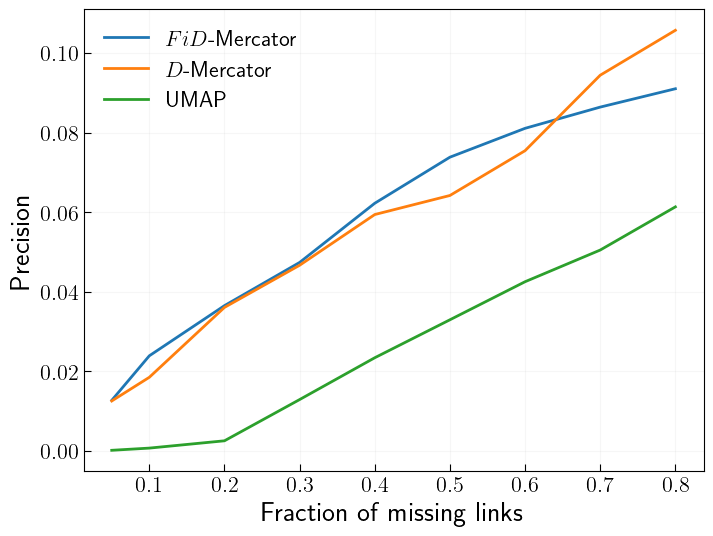

In [10]:
plt.plot(q_fractions, [np.mean(x) for x in umap_ml_precisions], label=r'$FiD$-Mercator')
plt.plot(q_fractions, [np.mean(x) for x in le_ml_precisions], label=r'$D$-Mercator')
plt.plot(q_fractions, [np.mean(x) for x in only_umap_precisions], label='UMAP')

plt.legend()
plt.xlabel('Fraction of missing links')
plt.ylabel('Precision')

Text(0.5, 1.0, 'LastFM')

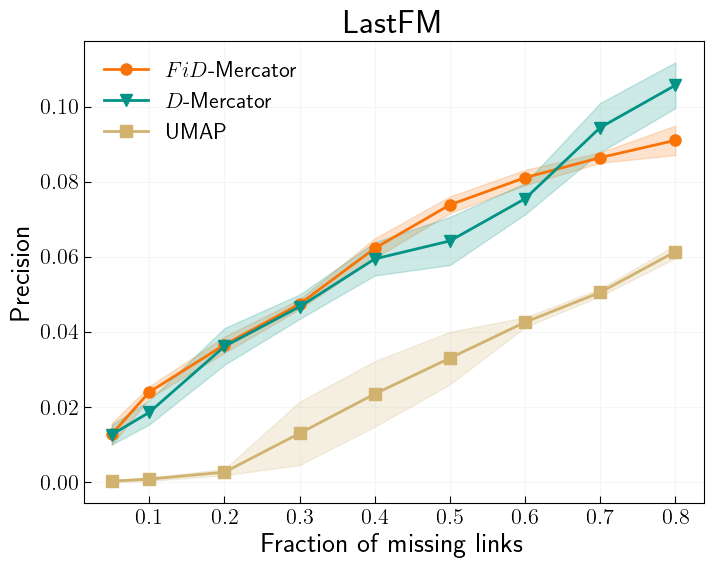

In [11]:
plt.plot(q_fractions, [np.mean(x) for x in umap_ml_precisions], 'o-', 
         color='xkcd:orange', label=r'$FiD$-Mercator')
plt.plot(q_fractions, [np.mean(x) for x in le_ml_precisions], 'v-', 
         color='xkcd:teal', label=r'$D$-Mercator')
plt.plot(q_fractions, [np.mean(x) for x in only_umap_precisions], 's-', 
         color='xkcd:tan', label='UMAP')

y = np.array([np.mean(x) for x in umap_ml_precisions])
y_std = np.array([np.std(x) for x in umap_ml_precisions])
plt.fill_between(q_fractions, y+y_std, y-y_std, color='xkcd:orange', alpha=0.2)

y = np.array([np.mean(x) for x in le_ml_precisions])
y_std = np.array([np.std(x) for x in le_ml_precisions])
plt.fill_between(q_fractions, y+y_std, y-y_std, color='xkcd:teal', alpha=0.2)

y = np.array([np.mean(x) for x in only_umap_precisions])
y_std = np.array([np.std(x) for x in only_umap_precisions])
plt.fill_between(q_fractions, y+y_std, y-y_std, color='xkcd:tan', alpha=0.2)

plt.legend()
plt.xlabel('Fraction of missing links')
plt.ylabel('Precision')
plt.title('LastFM')

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/link-prediction-incomplete-networks-27-12-23/plots/lp_lastfm.pdf")


Text(0.5, 1.0, 'LastFM')

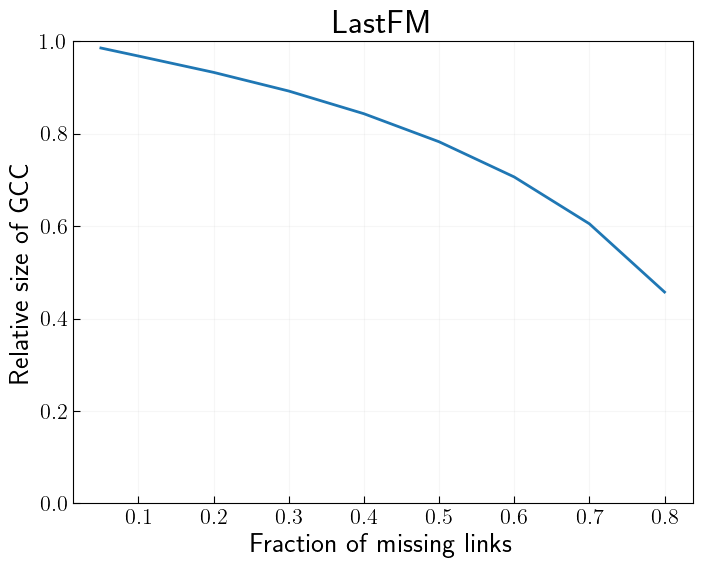

In [12]:
plt.plot(q_fractions, [np.mean(x) / nx.number_of_nodes(lastfm_graph) for x in gcc_sizes])
plt.xlabel('Fraction of missing links')
plt.ylabel('Relative size of GCC')
plt.ylim(0, 1)
plt.title('LastFM')

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/link-prediction-incomplete-networks-27-12-23/plots/gcc_lastfm.pdf")


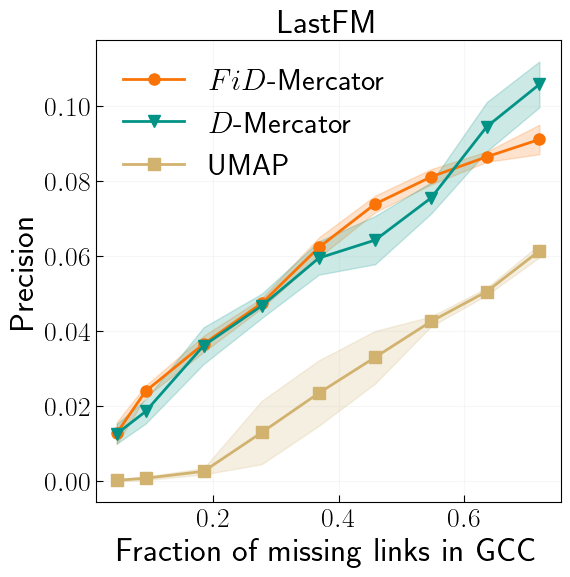

In [14]:
plt.figure(figsize=(6, 6))

plt.plot([np.mean(x) for x in umap_ml_new_q], [np.mean(x) for x in umap_ml_precisions], 'o-', 
         color='xkcd:orange', label=r'$FiD$-Mercator')
plt.plot([np.mean(x) for x in le_ml_new_q], [np.mean(x) for x in le_ml_precisions], 'v-', 
         color='xkcd:teal', label=r'$D$-Mercator')
plt.plot([np.mean(x) for x in only_umap_new_q], [np.mean(x) for x in only_umap_precisions], 's-', 
         color='xkcd:tan', label='UMAP')

y = np.array([np.mean(x) for x in umap_ml_precisions])
y_std = np.array([np.std(x) for x in umap_ml_precisions])
plt.fill_between([np.mean(x) for x in umap_ml_new_q], y+y_std, y-y_std, color='xkcd:orange', alpha=0.2)

y = np.array([np.mean(x) for x in le_ml_precisions])
y_std = np.array([np.std(x) for x in le_ml_precisions])
plt.fill_between([np.mean(x) for x in le_ml_new_q], y+y_std, y-y_std, color='xkcd:teal', alpha=0.2)

y = np.array([np.mean(x) for x in only_umap_precisions])
y_std = np.array([np.std(x) for x in only_umap_precisions])
plt.fill_between([np.mean(x) for x in only_umap_new_q], y+y_std, y-y_std, color='xkcd:tan', alpha=0.2)


plt.legend(fontsize=22)
plt.ylabel('Precision', fontsize=24)
plt.xlabel('Fraction of missing links in GCC', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title('LastFM')

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/link-prediction-incomplete-networks-27-12-23/plots/lp_lastfm_rescale_q.pdf")
